# TO DO
* transforms

In [1]:
from torchvision import datasets, transforms, utils, models
import torch
from torch.utils.data import random_split, DataLoader
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
    
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# }

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
data_dir = '/storage/data/vinted'

clothes_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
    
class_names = clothes_dataset.classes
class_names

['coat', 'dress', 'jeans']

In [4]:
clothes_train, clothes_val = random_split(clothes_dataset, [480, 120])

In [5]:
train_loader = DataLoader(clothes_train, batch_size=32, num_workers=8)
val_loader = DataLoader(clothes_val, batch_size=32, num_workers=8)

In [6]:
# batch x shape
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [7]:
# batch y shape
next(iter(train_loader))[1].shape

torch.Size([32])

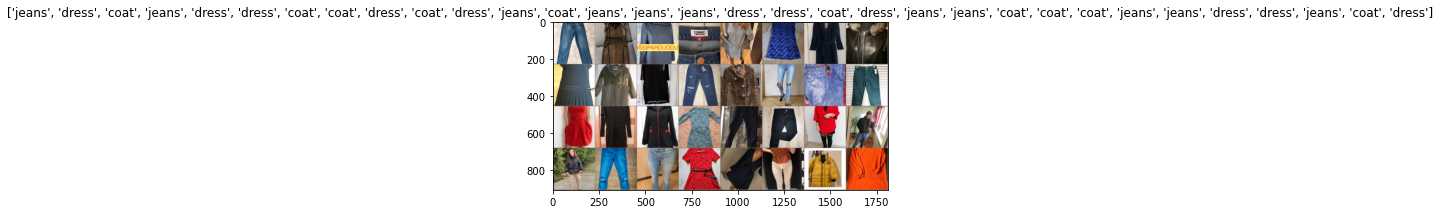

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = utils.make_grid(inputs)

class_names = clothes_dataset.classes

imshow(out, title=[class_names[x] for x in classes])

In [9]:
class ImageClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.train_acc = pl.metrics.Accuracy()
        self.valid_acc = pl.metrics.Accuracy()
        
        self.feature_extractor = models.resnet50(pretrained=True)
        self.feature_extractor.eval()
        
        self.classifier = nn.Linear(1000, 3)
        
    def forward(self, x):
        representations = self.feature_extractor(x)
        x = self.classifier(representations)
        
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_acc(y_hat, y)
        self.log('train_acc', self.train_acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', val_loss, prog_bar=True)
        self.valid_acc(y_hat, y)
        self.log('valid_acc', self.valid_acc, prog_bar=True)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [10]:
model = ImageClassifier()
model

ImageClassifier(
  (train_acc): Accuracy()
  (valid_acc): Accuracy()
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [11]:
trainer = pl.Trainer(gpus=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [12]:
trainer.fit(model, train_loader, val_loader)


  | Name              | Type     | Params
-----------------------------------------------
0 | train_acc         | Accuracy | 0     
1 | valid_acc         | Accuracy | 0     
2 | feature_extractor | ResNet   | 25 M  
3 | classifier        | Linear   | 3 K   


1

### TL:

loss=0.142, v_num=47, train_acc=0.875, val_loss=1.65, valid_acc=0.692

In [13]:
# import shutil
# shutil.rmtree('/storage/data/vinted/.ipynb_checkpoints')

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to('cpu')
            labels = labels.to('cpu')

            outputs = model(inputs)
            values, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, {values[j]}, actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

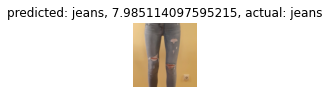

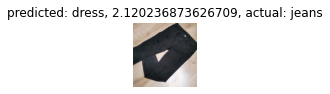

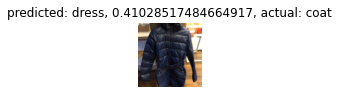

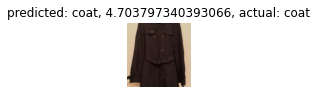

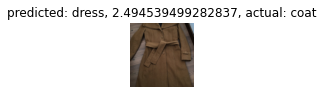

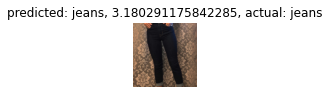

In [15]:
visualize_model(model)